In [1]:

import os
import numpy as np
import seaborn as sea
import tensorflow as tf 
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras.applications as Applications
import tensorflow.keras.preprocessing.image as ImagePreprocessing
import cv2
import pickle
import json
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense ,MaxPool2D ,BatchNormalization,Flatten ,Dropout
from sklearn.model_selection import KFold
from PIL import Image
import importlib.util
import zipfile
import random as rn
import pandas as pd
from sklearn.model_selection import train_test_split
from shutil import copyfile
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
from google.colab import drive

drive.mount('/content/drive')
sns.set()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

dataset_zip_local = '/content/drive/My Drive/kvasir-dataset-v2.zip'
zip_ref = zipfile.ZipFile(dataset_zip_local, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
train_split = 0.7
val_split = 0.15
test_split = 0.15
original_ds_path = '/tmp/kvasir-dataset-v2'
train_ds_path = 'train'
val_ds_path = 'validate'
test_ds_path = 'test'
base_dir = '/tmp'
losses_dir = base_dir+'/losses/'
model_save= base_dir+'/model_saves/'
seed = 49
size_img = (224,224) #size choosen to preserve the aspect ratio
input_size = (224,224,3)
batch_size = 32

In [4]:
ds_dic = {}
for folder in os.listdir(original_ds_path):
  ds_dic[folder] = os.listdir(original_ds_path+'/'+folder)

In [5]:
if not os.path.exists(train_ds_path):
      os.mkdir(train_ds_path)
if not os.path.exists(val_ds_path):
      os.mkdir(val_ds_path)
if not os.path.exists(test_ds_path):
      os.mkdir(test_ds_path)

for each in ds_dic:
    
    if not os.path.exists(train_ds_path+'/'+each+'/'):
        os.mkdir(train_ds_path+'/'+each+'/')
    if not os.path.exists(val_ds_path+'/'+each+'/'):
        os.mkdir(val_ds_path+'/'+each+'/')
    if not os.path.exists(test_ds_path+'/'+each+'/'):
        os.mkdir(test_ds_path+'/'+each+'/')

In [6]:

for each in ds_dic.keys():
  train_split , intermediate_split=train_test_split(ds_dic[each], 
                                              test_size=0.3, 
                                              random_state=seed,
                                              shuffle = True)
  
  val_split , test_split = train_test_split(intermediate_split, 
                                              test_size=0.5, 
                                              random_state=seed,
                                              shuffle = True)
  

  for img in train_split:
        destination = train_ds_path+'/'+each+'/'+img
        source = original_ds_path+'/'+each+'/'+img
        
        if not os.path.exists(destination):
            copyfile(source, destination)
        
  for img in test_split:
      destination = test_ds_path+'/'+each+'/'+img
      source = original_ds_path+'/'+each+'/'+img
      
      if not os.path.exists(destination):
          copyfile(source, destination)

  for img in val_split:
      destination = val_ds_path+'/'+each+'/'+img
      source = original_ds_path+'/'+each+'/'+img
      
      if not os.path.exists(destination):
          copyfile(source, destination)

In [7]:
train_datagen = ImageDataGenerator(featurewise_center=True,
                               samplewise_center=True,
                               featurewise_std_normalization=True,
                               samplewise_std_normalization=True,
                               zca_whitening=False,
                               zca_epsilon=1e-06,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2, 
                               brightness_range=None, 
                               shear_range=0.2, 
                               zoom_range=0.2,
                               channel_shift_range=0.0, 
                               fill_mode='nearest', 
                               cval=0.0, 
                               horizontal_flip=True,
                               vertical_flip=True, 
                               rescale=1./255, 
                               preprocessing_function=None,
                               validation_split=0.15
    )

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(directory=train_ds_path,
                                                    target_size=size_img,
                                                    batch_size=batch_size,
                                                    shuffle=True, 
                                                    seed=seed,
                                                    )
val_generator = val_datagen.flow_from_directory(directory=val_ds_path,
                                                    target_size=size_img,
                                                    batch_size=batch_size,
                                                    shuffle=True, 
                                                    seed=seed,
                                                    )
test_generator = test_datagen.flow_from_directory(directory=test_ds_path,
                                                    target_size=size_img,
                                                    batch_size=batch_size,
                                                    shuffle=True, 
                                                    seed=seed,
                                                    )

Found 5600 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


In [9]:

Base_Model = tf.keras.applications.DenseNet201(input_tensor=tf.keras.Input(shape=input_size),
                      weights='imagenet',
                      include_top=False)


In [10]:

for layer in Base_Model.layers:
    layer.trainable = False

In [11]:

conn_layer = Base_Model.get_layer('conv5_block18_concat')
conn_output = conn_layer.output
x = conn_output 
x = Conv2D(512,(3,3),activation='relu')(x)
x = Conv2D(512,(3,3),activation='relu')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128,activation='relu')(x)
predictions = Dense(8,activation='softmax')(x)

In [12]:
model = tf.keras.Model(inputs=Base_Model.input, outputs=predictions)

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adamax(lr=1e-2), 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                       ]
              )

In [14]:
try:
  if not os.path.exists(base_dir+'model_saves'):
    os.mkdir(model_save)
except FileExistsError:
  print('FileExists')

FileExists


In [15]:
train_history_list = {'initial':[],'secondary':[]}
val_history_list = {'initial':[],'secondary':[]}

In [16]:

for times in range(10):
    history = model.fit(x=train_generator,
                        epochs=5,
                        verbose=1,
                        )
    
    train_history_list['initial'].append(history)
    
    history = model.evaluate(x=val_generator,
                             verbose=1,
                             return_dict = True)
    
    val_history_list['initial'].append(history)

    model.save_weights(model_save+str(times)+'_init.h5')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
175/175 [==============================] - 183s 819ms/step - loss: 1.1166 - accuracy: 0.5877
Epoch 2/5
175/175 [==============================] - 142s 812ms/step - loss: 0.4863 - accuracy: 0.8040
Epoch 3/5
175/175 [==============================] - 142s 812ms/step - loss: 0.3974 - accuracy: 0.8453
Epoch 4/5
175/175 [==============================] - 142s 810ms/step - loss: 0.3801 - accuracy: 0.8425
Epoch 5/5
38/38 [==============================] - 24s 569ms/step - loss: 0.5413 - accuracy: 0.7750
Epoch 1/5
175/175 [==============================] - 143s 815ms/step - loss: 0.3346 - accuracy: 0.8684
Epoch 2/5
175/175 [==============================] - 146s 835ms/step - loss: 0.3315 - accuracy: 0.8652
Epoch 3/5
175/175 [==============================] - 145s 828ms/step - loss: 0.3045 - accuracy: 0.8827
Epoch 4/5
175/175 [==============================] - 144s 823ms/step - loss: 0.3081 - accuracy: 0.8834
Epoch 5/5
38/38 [==============================] - 19s 507ms/step - loss: 3.

In [17]:
try:
  if not os.path.exists(base_dir+'losses'):
    os.mkdir(losses_dir)
except FileExistsError:
  print('Folder exists')

Folder exists


In [18]:

train_history = []
for each in train_history_list['initial']:
  train_history.append(each.history)

val_history = []
for each in val_history_list['initial']:
  val_history.append(each)

In [19]:

with open(losses_dir+'train_history.json','w') as f0:
  json.dump(train_history,f0)

with open(losses_dir+'val_history.json','w') as f0:
  json.dump(val_history,f0)

In [20]:
for layer in model.layers:
    layer.trainable = False

In [21]:

for layer in model.layers[150:]:
    layer.trainable = True

In [22]:

train_history_list = {'initial':[],'secondary':[]}
val_history_list = {'initial':[],'secondary':[]}

In [23]:
from_epoch = 10
num_epochs = 50

In [24]:

for times in range(10):
    history = model.fit(x=train_generator,
                        epochs=5,
                        verbose=1,
                        )
    
    train_history_list['secondary'].append(history)
    
    history = model.evaluate(x=val_generator,
                             verbose=1,
                             return_dict = True)
    
    val_history_list['secondary'].append(history)

    model.save_weights(model_save+str(times)+'_secondary.h5')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
175/175 [==============================] - 141s 807ms/step - loss: 0.1494 - accuracy: 0.9445
Epoch 2/5
175/175 [==============================] - 141s 808ms/step - loss: 0.1479 - accuracy: 0.9411
Epoch 3/5
175/175 [==============================] - 142s 808ms/step - loss: 0.1570 - accuracy: 0.9389
Epoch 4/5
175/175 [==============================] - 141s 806ms/step - loss: 0.1435 - accuracy: 0.9420
Epoch 5/5
38/38 [==============================] - 19s 506ms/step - loss: 0.5147 - accuracy: 0.8333
Epoch 1/5
175/175 [==============================] - 142s 809ms/step - loss: 0.1372 - accuracy: 0.9430
Epoch 2/5
175/175 [==============================] - 142s 809ms/step - loss: 0.1453 - accuracy: 0.9446
Epoch 3/5
175/175 [==============================] - 141s 807ms/step - loss: 0.1448 - accuracy: 0.9429
Epoch 4/5
175/175 [==============================] - 141s 807ms/step - loss: 0.1425 - accuracy: 0.9438
Epoch 5/5
38/38 [==============================] - 19s 504ms/step - loss: 0.

In [25]:

train_history = []
for each in train_history_list['secondary']:
  train_history.append(each.history)

val_history = []
for each in val_history_list['secondary']:
  val_history.append(each)

In [26]:

with open(losses_dir+'train_history_secondary2.json','w') as f0:
  json.dump(train_history,f0)

with open(losses_dir+'val_history_secondary2.json','w') as f0:
  json.dump(val_history,f0)

In [27]:
train_loss = []
train_accuracy = []
val_accuracy = []
val_loss = []

with open(losses_dir+'train_history.json','r') as f0:
  file0 = json.load(f0)

for each in file0:
    train_loss+=each['loss']
    train_accuracy+=each['accuracy']


with open(losses_dir+'train_history_secondary2.json','r') as f0:
  file2 = json.load(f0)

for each in file2:
    train_loss+=each['loss']
    train_accuracy+=each['accuracy']
    
with open(losses_dir+'val_history.json','r') as f0:
  file3 = json.load(f0)

for each in file3:
    val_loss.append(each['loss'])
    val_accuracy.append(each['accuracy'])
    

with open(losses_dir+'val_history_secondary2.json','r') as f0:
  file5 = json.load(f0)

for each in file5:
    val_loss.append(each['loss'])
    val_accuracy.append(each['accuracy'])

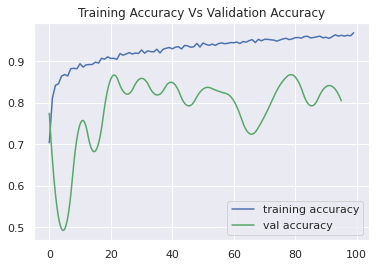

<Figure size 432x288 with 0 Axes>

In [38]:
from scipy.interpolate import interp1d

plt.plot(list(range(len(train_accuracy))),train_accuracy,'b',label='training accuracy')

val_x = 5*np.array(range(len(val_accuracy)))
val_y = val_accuracy
val_x_new = np.linspace(val_x.min(), val_x.max(),1500)
f = interp1d(val_x, val_y, kind='quadratic')
y_smooth = f(val_x_new)
plt.plot(val_x_new,y_smooth,'g',label='val accuracy')

plt.title('Training Accuracy Vs Validation Accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()